# Import Library

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, Dropout
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.losses import Huber

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from datetime import datetime

from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Data Understanding

In [ ]:
df = pd.read_csv('/content/drive/MyDrive/ETHHistorycalData/ethereum_price.csv')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,"Mar 08, 2023","1,553.49","1,561.79","1,569.70","1,548.98",498.57K,-0.53%
1,"Mar 07, 2023","1,561.78","1,565.84","1,580.95","1,536.31",460.10K,-0.26%
2,"Mar 06, 2023","1,565.84","1,564.36","1,581.13","1,555.43",322.16K,0.09%
3,"Mar 05, 2023","1,564.37","1,566.73","1,587.95","1,556.84",313.01K,-0.15%
4,"Mar 04, 2023","1,566.73","1,569.45","1,577.02","1,550.10",247.02K,-0.14%
...,...,...,...,...,...,...,...
2550,"Mar 14, 2016",12.50,15.07,15.07,11.40,92.18K,-17.05%
2551,"Mar 13, 2016",15.07,12.92,15.07,12.92,1.30K,16.64%
2552,"Mar 12, 2016",12.92,11.95,13.45,11.95,0.83K,8.12%
2553,"Mar 11, 2016",11.95,11.75,11.95,11.75,0.18K,1.70%


In [ ]:
df.isnull().sum()

Date        0
Price       0
Open        0
High        0
Low         0
Vol.        0
Change %    0
dtype: int64

## Change Date Format

In [ ]:
df['Date'] = pd.to_datetime(df['Date'], format='%b %d, %Y').dt.strftime('%Y-%m-%d')
df

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-03-08,"1,553.49","1,561.79","1,569.70","1,548.98",498.57K,-0.53%
1,2023-03-07,"1,561.78","1,565.84","1,580.95","1,536.31",460.10K,-0.26%
2,2023-03-06,"1,565.84","1,564.36","1,581.13","1,555.43",322.16K,0.09%
3,2023-03-05,"1,564.37","1,566.73","1,587.95","1,556.84",313.01K,-0.15%
4,2023-03-04,"1,566.73","1,569.45","1,577.02","1,550.10",247.02K,-0.14%
...,...,...,...,...,...,...,...
2550,2016-03-14,12.50,15.07,15.07,11.40,92.18K,-17.05%
2551,2016-03-13,15.07,12.92,15.07,12.92,1.30K,16.64%
2552,2016-03-12,12.92,11.95,13.45,11.95,0.83K,8.12%
2553,2016-03-11,11.95,11.75,11.95,11.75,0.18K,1.70%


In [ ]:
df = df[['Date', 'Price']]
df

,Date,Price
0,2023-03-08,"1,553.49"
1,2023-03-07,"1,561.78"
2,2023-03-06,"1,565.84"
3,2023-03-05,"1,564.37"
4,2023-03-04,"1,566.73"
...,...,...
2550,2016-03-14,12.50
2551,2016-03-13,15.07
2552,2016-03-12,12.92
2553,2016-03-11,11.95


## Data Normalization

In [ ]:
scaler = MinMaxScaler()
df['Price'] = df['Price'].str.replace(',', '').astype(float)
df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1,1))
type(df['Price'])

<ipython-input-6-fc791704b0fc>:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = df['Price'].str.replace(',', '').astype(float)
<ipython-input-6-fc791704b0fc>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['Price'] = scaler.fit_transform(df['Price'].values.reshape(-1,1))


pandas.core.series.Series

## ETH Price Chart

Text(0.5, 1.0, 'Prices')

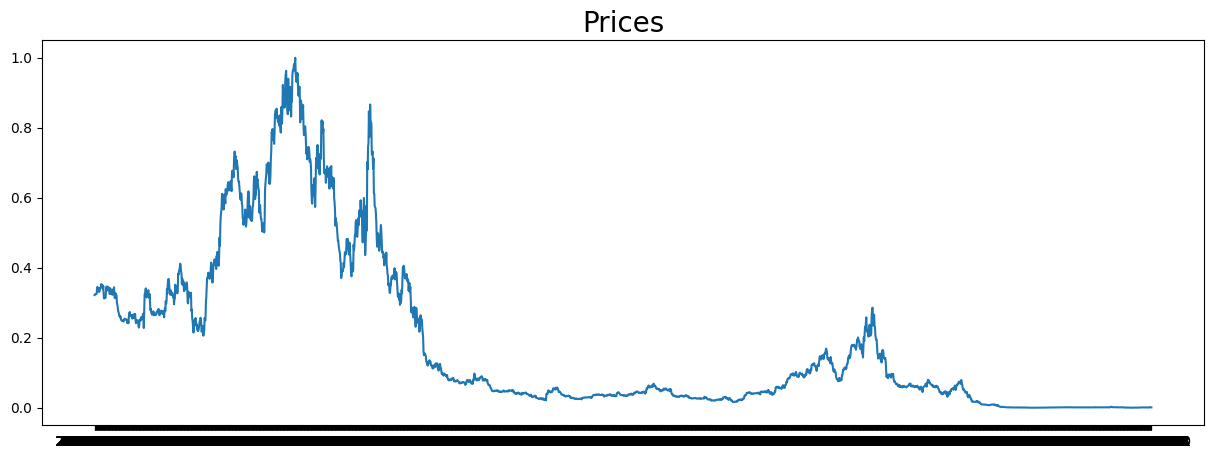

In [ ]:
dates = df['Date'].values
prices = df['Price'].values

plt.figure(figsize=(15,5))
plt.plot(dates, prices)
plt.title('Prices', fontsize=20)

# Data Preparation

In [ ]:
def windowed_dataset(series, window_size, batch_size, shuffle_buffer):
    series = tf.expand_dims(series, axis=-1)
    ds = tf.data.Dataset.from_tensor_slices(series)
    ds = ds.window(window_size + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda w: w.batch(window_size + 1))
    ds = ds.shuffle(shuffle_buffer)
    ds = ds.map(lambda w: (w[:-1], w[-1:]))
    return ds.batch(batch_size).prefetch(1)

In [ ]:
train_size = int(len(prices) * 0.8)
time = np.array(range(len(prices)))
series = np.array(prices)
x_train = series[:train_size]
x_valid = series[train_size:]

In [ ]:
train_set = windowed_dataset(
    x_train, window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

valid_set = windowed_dataset(
    x_valid, window_size=60,
    batch_size=100,
    shuffle_buffer=1000
)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


# Model Development

In [ ]:
model = Sequential([
    LSTM(60, return_sequences=True),
    LSTM(60),
    Dense(30, activation="relu"),
    Dropout(0.3),
    Dense(10, activation="relu"),
    Dropout(0.2),
    Dense(1),
])

In [ ]:
threshold_mae = (df['Price'].max() - df['Price'].min()) * 10/100

class EarlyStop(tf.keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs={}):
        if(logs.get('mae')<threshold_mae):
            print("mae < 10%")
            self.model.stop_training = True

callbacks = EarlyStop()

In [ ]:
optimizer = SGD(learning_rate=1.0000e-04, momentum=0.9)

model.compile(loss=Huber(),
              optimizer=optimizer,
              metrics=["mae", "accuracy"])

history = model.fit(train_set, epochs=100,
                    validation_data=valid_set,
                    callbacks=[callbacks],
                    batch_size=128)

Epoch 1/100
20/20 [==============================] - 10s 214ms/step - loss: 0.0450 - mae: 0.1992 - accuracy: 0.0000e+00 - val_loss: 7.4975e-05 - val_mae: 0.0118 - val_accuracy: 0.0022
Epoch 2/100
20/20 [==============================] - 4s 170ms/step - loss: 0.0415 - mae: 0.1819 - accuracy: 0.0000e+00 - val_loss: 4.7861e-04 - val_mae: 0.0304 - val_accuracy: 0.0022
Epoch 3/100
20/20 [==============================] - 3s 138ms/step - loss: 0.0374 - mae: 0.1684 - accuracy: 0.0000e+00 - val_loss: 0.0012 - val_mae: 0.0491 - val_accuracy: 0.0022
Epoch 4/100
20/20 [==============================] - 3s 127ms/step - loss: 0.0342 - mae: 0.1632 - accuracy: 0.0000e+00 - val_loss: 0.0022 - val_mae: 0.0662 - val_accuracy: 0.0022
Epoch 5/100
20/20 [==============================] - 4s 211ms/step - loss: 0.0325 - mae: 0.1626 - accuracy: 0.0000e+00 - val_loss: 0.0033 - val_mae: 0.0805 - val_accuracy: 0.0022
Epoch 6/100
20/20 [==============================] - 3s 131ms/step - loss: 0.0302 - mae: 0.1597 

# Model Evaluation

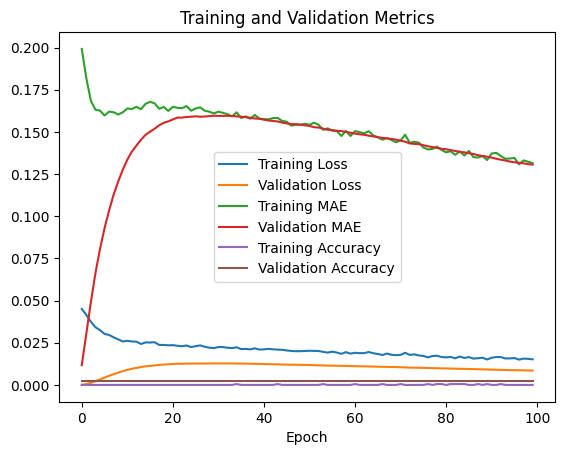

In [ ]:
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['mae'], label='Training MAE')
plt.plot(history.history['val_mae'], label='Validation MAE')
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Metrics')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [ ]:
test_loss, test_mae, test_accuracy = model.evaluate(valid_set)

print("Test Loss:", test_loss)
print("Test MAE:", test_mae)
print("Test Accuracy:", test_accuracy)


5/5 [==============================] - 1s 69ms/step - loss: 0.0085 - mae: 0.1306 - accuracy: 0.0022
Test Loss: 0.008534647524356842
Test MAE: 0.13058969378471375
Test Accuracy: 0.002217294881120324
